## Objective
This notebook tests whether baseline subgenual anterior cingulate cortex (sgACC) functional connectivity (FC) differs across sham and active tFUS sessions and whether stimulation drives condition-specific changes over time. The analysis focuses on sgACC-to-whole-brain edges extracted from the DiFuMo 1024 atlas and produces both statistical summaries and publication-ready plots.

### Generated Artifacts
- `statsmodels` mixed-effects output that quantifies main effects for time, condition, and their interaction.
- A tidy table of fitted means stored in-memory (`pred_grid`) for quick inspection or downstream export.
- The figure `../figures/fc_change_vs_fc_baseline_violin_plot.png`, which is referenced in the manuscript Results section.

### Data Dependencies and Inputs
- `../data/precomputed/df_fc.pkl`: tidy table containing the columns `subject`, `condition`, `time_window`, `fc`, `roi1`, and `roi2`. Each row corresponds to a pairwise FC estimate between atlas parcels.
- DiFuMo 1024 atlas downloaded through `nilearn.datasets.fetch_atlas_difumo`. The downloader caches files under `~/nilearn_data`, so no additional files need to be tracked in the repository.
- Output paths assume the default project tree (`../figures/` relative to this notebook). Adjust the paths if you mirror the analysis outside of this repository.

### Execution Workflow
1. Import common neuroimaging and statistics packages (NumPy, pandas, Nilearn, StatsModels, Matplotlib, and Seaborn).
2. Load the pre-computed FC dataframe and identify sgACC parcels via the DiFuMo atlas labels.
3. Flag and subset all sgACC-containing edges, then collapse them into subject-level mean FC values for each condition and time window.
4. Fit a linear mixed-effects model with a subject-level random intercept to capture differences attributable to stimulation condition, time, and their interaction.
5. Build a tidy prediction grid for quick effect-size inspection.
6. Visualize sham vs. active trajectories with paired violin/strip plots and save the resulting figure for manuscript use.

### Reproducibility and Sharing Notes
- Activate the project environment (`conda activate fus-bold` or equivalent) before executing the notebook so that StatsModels, Nilearn, and plotting libraries are available.
- Confirm that `../data/precomputed/df_fc.pkl` reflects the finalized preprocessing pipeline; regenerate the pickle if upstream scripts change any column names or filtering rules.
- When re-running in continuous integration or headless environments, use `jupyter nbconvert --to notebook --execute code/analyze_fc_change_vs_fc_baseline.ipynb` to capture cell outputs and verify that the saved figure refreshes.
- The notebook is deterministic apart from Seaborn's strip-plot jitter; set `np.random.seed(...)` at the top if you need identical point placements across renders.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting, signal
from scipy import stats
import statsmodels.formula.api as smf

In [30]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)

In [31]:
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
#atlas_img = nib.load(difumo.maps)
subgenual = df_labels.loc[133,'difumo_names']
subgenual

'Subgenual cortex'

In [32]:
df["is_roi1_subgenual"] = df["roi1"] == subgenual
df["is_roi2_subgenual"] = df["roi2"] == subgenual
df["is_pair_subgenual"] = df["is_roi1_subgenual"] | df["is_roi2_subgenual"]
df["is_pair_subgenual"].sum()

np.int64(98208)

In [33]:
df_sg = df[df["is_pair_subgenual"]].copy()
df_sg["roi_pair"] = ["__".join(sorted((r1, r2))) for r1, r2 in zip(df_sg["roi1"], df_sg["roi2"])]

## Mixed Effects Model\nWe treat subject-level mean sgACC FC (`fc`) as the dependent variable and model it as a function of time window (`pre`, `fus`, `post`) and stimulation condition (`sham`, `active`). The formula implemented in `statsmodels.mixedlm` is:\n\n```\nfc ~ C(time_window, Treatment(reference='pre')) * C(condition, Treatment(reference='sham'))\n```\n\nKey features:\n- **Random intercept per subject**: accounts for baseline differences and repeated-measures structure.\n- **Treatment coding**: estimates interpretable contrasts relative to the pre-sham baseline.\n- **Interaction term**: tests whether active stimulation alters FC trajectories beyond any sham-related drift.\n\nUse the printed summary to extract coefficient estimates, 95\% confidence intervals, and p-values for the manuscript text and to contextualize the annotations that appear on the violin plot.

In [34]:
# --------------------------------------------------------------------
# 0. Create working dataframe and remove unnecessary columns
#   Assumes df_sg has columns: subject, condition, time_window, fc
# --------------------------------------------------------------------
dfw = df_sg.copy().drop(columns=["roi1", "roi2", "is_roi1_subgenual", "is_roi2_subgenual", "is_pair_subgenual","roi_pair"]).reset_index(drop=True)

# --------------------------------------------------------------------
# 1. Subject-level means (avoids treating edges as independent)
#    Assumes dfw has columns: subject, condition, time_window, fc
# --------------------------------------------------------------------
dfw_mu = (
    dfw
    .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
    .mean()
)

# --------------------------------------------------------------------
# 2. Categorical coding with explicit reference levels
#    Make sure the categories match your actual labels:
#    use ["pre", "stim", "post"] if that's what you used instead of "fus"
# --------------------------------------------------------------------
dfw_mu["time_window"] = pd.Categorical(
    dfw_mu["time_window"],
    categories=["pre", "fus", "post"],
    ordered=False
)

dfw_mu["condition"] = pd.Categorical(
    dfw_mu["condition"],
    categories=["sham", "active"],
    ordered=False
)

# --------------------------------------------------------------------
# 3. Mixed-effects model:
#    fc ~ time_window * condition
#    - Reference: sham at pre
#    - Random intercept: subject
# --------------------------------------------------------------------
model = smf.mixedlm(
    "fc ~ C(time_window, Treatment(reference='pre')) "
    "* C(condition, Treatment(reference='sham'))",
    dfw_mu,
    groups=dfw_mu["subject"],
    re_formula="1",
    missing="drop"
)

result = model.fit(method="lbfgs", reml=True)
print(result.summary())

# --------------------------------------------------------------------
# 4. (Optional) Extract cell means for plotting / sanity check
# --------------------------------------------------------------------
# Build a small table of fitted means by condition × time_window
pred_grid = (
    dfw_mu[["condition", "time_window"]]
    .drop_duplicates()
    .sort_values(["condition", "time_window"])
)

pred_grid["fc_pred"] = result.predict(pred_grid)
print("\nFitted means by condition × time_window:")
print(pred_grid)

                                                      Mixed Linear Model Regression Results
Model:                                            MixedLM                               Dependent Variable:                               fc     
No. Observations:                                 96                                    Method:                                           REML   
No. Groups:                                       16                                    Scale:                                            0.0055 
Min. group size:                                  6                                     Log-Likelihood:                                   91.7147
Max. group size:                                  6                                     Converged:                                        Yes    
Mean group size:                                  6.0                                                                                            
--------------------------------

/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Violin Plot Figure
The final visualization pairs violin plots with subject-level trajectories to illustrate how sgACC FC evolves across `pre`, `tFUS`, and `post` windows for each condition. Sham and active panels share the same y-axis limits to ease comparison, and textual annotations call out the key statistical results from the mixed model (baseline offsets and post-stimulation differences). The plot is exported to `../figures/fc_change_vs_fc_baseline_violin_plot.png` at 300 DPI so it can be version-controlled and imported directly into the manuscript's Results figure. Re-run the last cell after updating the dataframe to refresh the figure on disk.

<>:180: SyntaxWarning: invalid escape sequence '\D'
<>:180: SyntaxWarning: invalid escape sequence '\D'
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_54528/2418378689.py:180: SyntaxWarning: invalid escape sequence '\D'
  "Pre→post $\Delta$ active > sham\n($p=0.033$)",
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_54528/2418378689.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Pre", "tFUS", "Post"])
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_54528/2418378689.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Pre", "tFUS", "Post"])


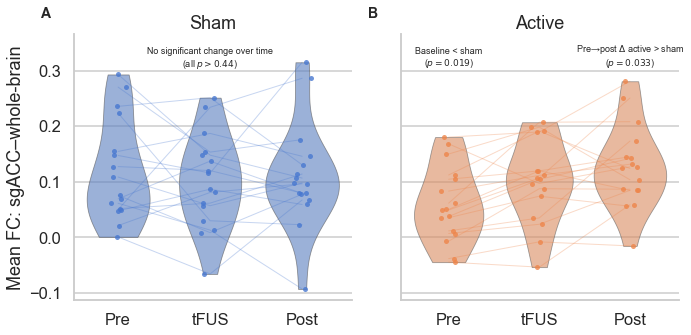

In [35]:
# ---------------------------------------------------------------------
# Assumes dfw has columns: subject, condition, time_window, fc
# and time_window labels: "pre", "fus", "post"
# ---------------------------------------------------------------------

# 1. Subject-level means (same aggregation as mixed model)
dfw_mu = (
    dfw
    .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
    .mean()
)

time_order = ["pre", "fus", "post"]
cond_order = ["sham", "active"]

dfw_mu["time_window"] = pd.Categorical(
    dfw_mu["time_window"],
    categories=time_order,
    ordered=True
)
dfw_mu["condition"] = pd.Categorical(
    dfw_mu["condition"],
    categories=cond_order,
    ordered=False
)

# Helper: map time_window to x positions
time_idx = {t: i for i, t in enumerate(time_order)}

# ---------------------------------------------------------------------
# 2. Plot setup
# ---------------------------------------------------------------------
sns.set_theme(style="whitegrid", context="talk")
palette = sns.color_palette("muted")
color_sham = palette[0]
color_active = palette[1]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# =========================
# (A) Sham: raw FC
# =========================
ax = axes[0]
data_sham = dfw_mu[dfw_mu["condition"] == "sham"]

sns.violinplot(
    data=data_sham,
    x="time_window",
    y="fc",
    order=time_order,
    inner=None,
    cut=0,
    linewidth=0.8,
    ax=ax,
    color=color_sham
)

# make violins slightly transparent
for c in ax.collections:
    c.set_alpha(0.6)

sns.stripplot(
    data=data_sham,
    x="time_window",
    y="fc",
    order=time_order,
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=5,
    ax=ax,
    color=color_sham
)

# connect each subject's trajectory (thin, subtle)
for subj, sdf in data_sham.groupby("subject"):
    sdf = sdf.sort_values("time_window")
    ax.plot(
        [time_idx[t] for t in sdf["time_window"]],
        sdf["fc"].values,
        alpha=0.3,
        linewidth=1,
        color=color_sham
    )

ax.set_xticklabels(["Pre", "tFUS", "Post"])
ax.set_title("Sham")
ax.set_xlabel("")
ax.set_ylabel("Mean FC: sgACC–whole-brain")
sns.despine(ax=ax)

# expand y-limit slightly to make room for text
ylims = ax.get_ylim()
ax.set_ylim((ylims[0], ylims[1] + 0.03))

# Annotate: no significant time effect
ymax_sham = data_sham["fc"].max()
ax.text(
    1,
    ymax_sham - 0.015,
    "No significant change over time\n(all $p>0.44$)",
    ha="center", va="bottom",
    fontsize=9
)

# Panel label (A)
ax.text(
    -0.12, 1.05, "A",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=14, fontweight="bold"
)

# =========================
# (B) Active: raw FC + key stats
# =========================
ax = axes[1]
data_active = dfw_mu[dfw_mu["condition"] == "active"]

sns.violinplot(
    data=data_active,
    x="time_window",
    y="fc",
    order=time_order,
    inner=None,
    cut=0,
    linewidth=0.8,
    ax=ax,
    color=color_active
)

for c in ax.collections:
    c.set_alpha(0.6)

sns.stripplot(
    data=data_active,
    x="time_window",
    y="fc",
    order=time_order,
    dodge=False,
    jitter=True,
    alpha=0.8,
    size=5,
    ax=ax,
    color=color_active
)

for subj, sdf in data_active.groupby("subject"):
    sdf = sdf.sort_values("time_window")
    ax.plot(
        [time_idx[t] for t in sdf["time_window"]],
        sdf["fc"].values,
        alpha=0.3,
        linewidth=1,
        color=color_active
    )

ax.set_xticklabels(["Pre", "tFUS", "Post"])
ax.set_title("Active")
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(ax=ax)

ymax_act = data_active["fc"].max()

# Annotations based on mixed model:
# - Baseline difference: active < sham at pre (p = 0.019)
ax.text(
    time_idx["pre"],
    ymax_act + 0.02,
    "Baseline < sham\n($p=0.019$)",
    ha="center", va="bottom",
    fontsize=9
)

# - Pre→post difference-in-differences: active > sham (p = 0.033)
ax.text(
    time_idx["post"],
    ymax_act + 0.02,
    "Pre→post $\Delta$ active > sham\n($p=0.033$)",
    ha="center", va="bottom",
    fontsize=9
)

# Panel label (B)
ax.text(
    -0.12, 1.05, "B",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=14, fontweight="bold"
)

plt.tight_layout()

plt.savefig('../figures/fc_change_vs_fc_baseline_violin_plot.png', dpi=300)
plt.show()

In [36]:

# Clean ANCOVA: baseline-adjusted OLS with subject fixed effects, proper factor levels.
# Outcome: FC at fus/post
# Covariate: fc_pre (subject×condition baseline)
# FE: C(subject)
# Tests: (a) Active vs Sham at POST (baseline-adjusted)
#        (b) fus→post difference-in-differences (interaction)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# --- 0) Start from subject-level means (same aggregation as your LME) ---
if "dfw_mu" not in globals():
    assert "dfw" in globals(), "Need `dfw` with columns: subject, condition, time_window, fc."
    dfw_mu = (
        dfw
        .groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
        .mean()
    )

# Normalize labels
dfw_mu = dfw_mu.copy()
if dfw_mu["time_window"].isin(["stim"]).any():
    dfw_mu["time_window"] = dfw_mu["time_window"].replace({"stim": "fus"})

# --- 1) Add baseline covariate per subject×condition ---
pre = (
    dfw_mu[dfw_mu["time_window"] == "pre"]
    .loc[:, ["subject", "condition", "fc"]]
    .rename(columns={"fc": "fc_pre"})
)
df_anc = dfw_mu.merge(pre, on=["subject", "condition"], how="left")

# Keep fus/post only as outcomes
df_anc = df_anc[df_anc["time_window"].isin(["fus", "post"])].copy()

# Critically: DROP UNUSED CATEGORIES to prevent a phantom [T.pre] column
df_anc["time_window"] = pd.Categorical(df_anc["time_window"], categories=["fus", "post"], ordered=True)
df_anc["condition"]   = pd.Categorical(df_anc["condition"],   categories=["sham", "active"])

# --- 2) Fit ANCOVA with subject FE + baseline covariate (clustered SE by subject) ---
formula = (
    "fc ~ C(time_window, Treatment(reference='fus')) "
    "* C(condition, Treatment(reference='sham')) "
    "+ fc_pre + C(subject)"
)
mod = smf.ols(formula, data=df_anc)
res = mod.fit(cov_type="cluster", cov_kwds={"groups": df_anc["subject"]})
print(res.summary())

# --- 3) Focused contrasts ---
params = res.params.index.tolist()
term_cond = "C(condition, Treatment(reference='sham'))[T.active]"
term_post = "C(time_window, Treatment(reference='fus'))[T.post]"
term_int  = f"{term_post}:{term_cond}"

# (a) Active vs Sham at POST (baseline-adjusted)
L_post = np.zeros(len(params))
for i, nm in enumerate(params):
    if nm == term_cond or nm == term_int:
        L_post[i] = 1.0
print("\n=== Contrast: Active vs Sham at POST (baseline-adjusted) ===")
print(res.t_test(L_post))

# (b) fus→post difference-in-differences (interaction only)
L_int = np.zeros(len(params))
for i, nm in enumerate(params):
    if nm == term_int:
        L_int[i] = 1.0
print("\n=== Contrast: Differential change fus→post (Active − Sham) ===")
print(res.t_test(L_int))


                            OLS Regression Results                            
Dep. Variable:                     fc   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     1.391
Date:                Mon, 17 Nov 2025   Prob (F-statistic):              0.284
Time:                        09:18:52   Log-Likelihood:                 89.905
No. Observations:                  64   AIC:                            -139.8
Df Residuals:                      44   BIC:                            -96.63
Df Model:                          19                                         
Covariance Type:              cluster                                         
                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [37]:


# ------------------------------------------------------------
# 4) Optional: Check slope homogeneity (does baseline relate to change differently by condition?)
#    Add fc_pre × condition; the interaction term tests differential RTM slopes.
# ------------------------------------------------------------
formula_slope = (
    "fc ~ C(time_window, Treatment(reference='fus')) "
    "* C(condition, Treatment(reference='sham')) "
    "+ fc_pre * C(condition, Treatment(reference='sham')) + C(subject)"
)
res_anc_slope = smf.ols(formula_slope, data=df_anc).fit(
    cov_type="cluster", cov_kwds={"groups": df_anc["subject"]}
)

print("\n\n=== ANCOVA with baseline×condition slope check ===")
print(res_anc_slope.summary())



=== ANCOVA with baseline×condition slope check ===
                            OLS Regression Results                            
Dep. Variable:                     fc   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     2.368
Date:                Mon, 17 Nov 2025   Prob (F-statistic):             0.0898
Time:                        09:18:52   Log-Likelihood:                 98.607
No. Observations:                  64   AIC:                            -155.2
Df Residuals:                      43   BIC:                            -109.9
Df Model:                          20                                         
Covariance Type:              cluster                                         
                                                                                                             coef    std err          z      P>|z|      [0.02

/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 5
  warnings.warn('covariance of constraints does not have full '


/opt/miniconda3/envs/fus/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 4
  warnings.warn('covariance of constraints does not have full '
/var/folders/g9/8jw7l6116kdd4pc549qnnz8r0000gn/T/ipykernel_54528/2528315351.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for tw, g in dat.groupby("time_window"):


                            OLS Regression Results                            
Dep. Variable:               delta_fc   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     4.224
Date:                Mon, 17 Nov 2025   Prob (F-statistic):             0.0173
Time:                        09:18:52   Log-Likelihood:                 98.356
No. Observations:                  64   AIC:                            -156.7
Df Residuals:                      44   BIC:                            -113.5
Df Model:                          19                                         
Covariance Type:              cluster                                         
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

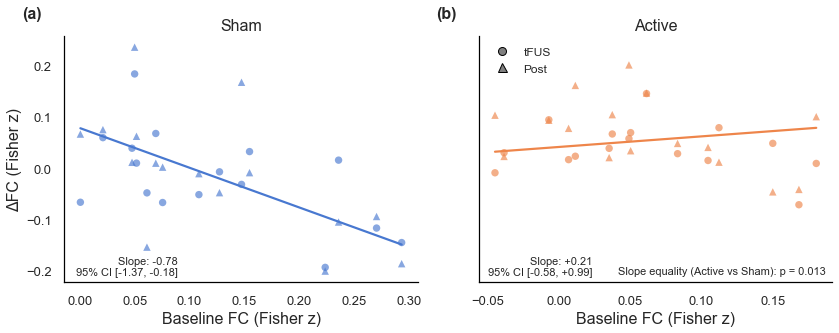

In [38]:
# Two-panel figure: (a) Sham, (b) Active
# Baseline (pre) sgACC FC vs ΔFC (pooled fit across tFUS+Post),
# with subject fixed effects and time-window FE used for slopes.
# Saves: ../figures/rtm_slope_pooled_2panel.png

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D

# 1) Subject-level means and ΔFC
if "dfw_mu" not in globals():
    assert "dfw" in globals(), "Need `dfw` with columns: subject, condition, time_window, fc."
    dfw_mu = (
        dfw.groupby(["subject", "condition", "time_window"], as_index=False)["fc"]
           .mean()
    )

dfw_mu = dfw_mu.copy()
# Normalize label if needed
if dfw_mu["time_window"].isin(["stim"]).any():
    dfw_mu["time_window"] = dfw_mu["time_window"].replace({"stim": "fus"})

# Build baseline & delta
pre = (dfw_mu[dfw_mu["time_window"] == "pre"]
       .loc[:, ["subject", "condition", "fc"]]
       .rename(columns={"fc": "fc_pre"}))
df_rt = dfw_mu.merge(pre, on=["subject", "condition"], how="left")
df_rt = df_rt[df_rt["time_window"].isin(["fus", "post"])].copy()
df_rt["delta_fc"] = df_rt["fc"] - df_rt["fc_pre"]

# Factors
df_rt["condition"]   = pd.Categorical(df_rt["condition"],   categories=["sham", "active"])
df_rt["time_window"] = pd.Categorical(df_rt["time_window"], categories=["fus", "post"], ordered=True)

# Center baseline (doesn't change slopes; improves numerics)
df_rt["fc_pre_c"] = df_rt["fc_pre"] - df_rt["fc_pre"].mean()

# 2) Pooled subject-FE model: ΔFC ~ fc_pre_c * condition + C(time_window) + C(subject)
mod_pool = smf.ols(
    "delta_fc ~ fc_pre_c * C(condition, Treatment(reference='sham')) + "
    "C(time_window, Treatment(reference='fus')) + C(subject)",
    data=df_rt
)
res_pool = mod_pool.fit(cov_type="cluster", cov_kwds={"groups": df_rt["subject"]})
print(res_pool.summary())

# Extract condition-specific slopes + 95% CIs and slope-equality p-value
p = res_pool.params; V = res_pool.cov_params()
base = [nm for nm in p.index if nm == "fc_pre_c"]
if not base:
    base = [nm for nm in p.index if nm.startswith("fc_pre_c")]
base = base[0]
int_term = [nm for nm in p.index if nm.startswith("fc_pre_c:C(condition")]
int_term = int_term[0]

slope_sham   = p[base]
se_sham      = np.sqrt(V.loc[base, base])
ci_sham      = (slope_sham - 1.96*se_sham, slope_sham + 1.96*se_sham)

slope_active = p[base] + p[int_term]
se_active    = np.sqrt(V.loc[base, base] + V.loc[int_term, int_term] + 2*V.loc[base, int_term])
ci_active    = (slope_active - 1.96*se_active, slope_active + 1.96*se_active)

# slope-equality test (Active vs Sham)
L = np.zeros(len(p))
L[p.index.get_loc(int_term)] = 1.0
test_eq = res_pool.t_test(L)
p_slope = float(test_eq.pvalue)

# 3) Plot settings
sns.set_theme(context="talk", style="white")
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.25,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 12,
})
palette = sns.color_palette("muted")
color_sham, color_active = palette[0], palette[1]
marker_map = {"fus": "o", "post": "^"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

def draw_condition_panel(ax, dat, cond, color, slope, ci, panel_label):
    # Scatter: shape encodes window
    for tw, g in dat.groupby("time_window"):
        ax.scatter(
            g["fc_pre"], g["delta_fc"],
            s=55, alpha=0.65, edgecolor="none",
            color=color, marker=marker_map[str(tw)],
            label=("tFUS" if tw=="fus" else "Post")
        )

    # Regression line anchored at condition means
    x0 = dat["fc_pre"].mean()
    y0 = dat["delta_fc"].mean()
    xs = np.linspace(dat["fc_pre"].min(), dat["fc_pre"].max(), 200)
    y_line = y0 + slope * (xs - x0)
    ax.plot(xs, y_line, color=color, linewidth=2.2)

    # Axes styling
    ax.set_title(cond.capitalize())
    ax.set_xlabel("Baseline FC (Fisher z)")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Annotation: slope ± 95% CI
    ax.text(
        0.32, 0.02,
        f"Slope: {slope:+.2f}\n95% CI [{ci[0]:+.2f}, {ci[1]:+.2f}]",
        transform=ax.transAxes, ha="right", va="bottom", fontsize=11
    )

    # Panel label (a)/(b)
    ax.text(-0.12, 1.06, panel_label, transform=ax.transAxes,
            ha="left", va="bottom", fontsize=16, fontweight="bold")

# Subset data
d_sham   = df_rt[df_rt["condition"] == "sham"]
d_active = df_rt[df_rt["condition"] == "active"]

# Draw panels
draw_condition_panel(axes[0], d_sham,   "sham",   color_sham,   slope_sham,   ci_sham,   "(a)")
draw_condition_panel(axes[1], d_active, "active", color_active, slope_active, ci_active, "(b)")

# Y label on left only
axes[0].set_ylabel("ΔFC (Fisher z)")
axes[1].set_ylabel("")

# Unified legend for markers (time windows) — put on the right panel
legend_elems = [
    Line2D([0], [0], marker=marker_map["fus"],  color='none', label='tFUS', markerfacecolor='gray', markersize=8),
    Line2D([0], [0], marker=marker_map["post"], color='none', label='Post',  markerfacecolor='gray', markersize=9),
]
axes[1].legend(handles=legend_elems, loc="upper left", frameon=False, title=None)

# Add global annotation for slope equality
axes[1].text(
    0.98, 0.065, f"Slope equality (Active vs Sham): p = {p_slope:.3f}",
    transform=axes[1].transAxes, ha="right", va="top", fontsize=11
)

plt.tight_layout()
plt.savefig("../figures/rtm_slope_pooled_2panel.png", dpi=300, bbox_inches="tight")
plt.show()